# Oasis 2 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import nibabel as nib
from scipy import ndimage

import zipfile
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
oasis2_df = pd.read_csv('data/oasis2/oasis_longitudinal_demographics.csv')

In [ ]:
oasis2_df.columns

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [ ]:
oasis2_df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    scan = np.squeeze(scan) # remove axis with length 1
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
#     img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
#     volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

def get_nifti_file_paths(cdr_value, oasis2_df):
    datapath = 'D:\\jupyter_notebooks\\ds2\\project\\data\\oasis2\\OAS2_RAW'
    file_ext = 'img'
    paths = []
    
    for mri_id in os.listdir(datapath):
        curr_cdr = oasis2_df.loc[oasis2_df['MRI ID'] == mri_id, 'CDR'].iloc[0]
        
        if curr_cdr == cdr_value:
            for root, dirpath, files in os.walk(os.path.join(datapath, mri_id)):
                for item in files:
                    ext = item.split('.')[-1]
                    if ext == 'img':
                        paths.append(os.path.join(root, item))
    
    return paths

In [ ]:
class DataHandler(): 
    
    def __init__(self, scan_paths):
        self.nondemented_scan_paths = scan_paths[0]
        self.very_mild_ad_scan_paths = scan_paths[1]
        self.mild_ad_scan_paths = scan_paths[2]
        self.moderate_ad_scan_paths = scan_paths[3]
        self.dataset = tf.data.Dataset.from_generator(
            self.getData,
            output_signature=(
                tf.TensorSpec(shape=(128, 128, 64), dtype=tf.float64),
                 tf.TensorSpec(shape=(4), dtype=tf.uint8)))
    
    def getData(self):
        
        scan_paths = np.concatenate(
            (
                self.nondemented_scan_paths, 
                self.very_mild_ad_scan_paths, 
                self.mild_ad_scan_paths, 
                self.moderate_ad_scan_paths
            ), 
            axis=0
        )

        self.nondemented_labels = np.array([0 for _ in range(len(self.nondemented_scan_paths))])
        self.very_mild_ad_labels = np.array([1 for _ in range(len(self.very_mild_ad_scan_paths))])
        self.mild_ad_labels = np.array([2 for _ in range(len(self.mild_ad_scan_paths))])
        self.moderate_ad_labels = np.array([3 for _ in range(len(self.moderate_ad_scan_paths))])        

        scan_labels = np.concatenate(
            (
                self.nondemented_labels, 
                self.very_mild_ad_labels, 
                self.mild_ad_labels, 
                self.moderate_ad_labels
            ), 
            axis=0
        )
        
        scan_labels = keras.utils.to_categorical(scan_labels, num_classes=4)
        
#         print(len(scan_paths))
        random_indices = np.arange(len(scan_paths))
        np.random.shuffle(random_indices)
        
        for idx in random_indices:
            scan = process_scan(scan_paths[idx])
            yield scan, scan_labels[idx]
        

In [ ]:
# Get the filepaths of the scans of different classes (CDR 0, 0.5, 1.0, 2.0)
nondemented_scan_paths = get_nifti_file_paths(0.0, oasis2_df)
very_mild_ad_scan_paths = get_nifti_file_paths(0.5, oasis2_df)
mild_ad_scan_paths = get_nifti_file_paths(1.0, oasis2_df)
moderate_ad_scan_paths = get_nifti_file_paths(2.0, oasis2_df)

In [ ]:
print('Number of scans for each class:\n')
print(f'Nondemented: {len(nondemented_scan_paths)}')
print(f'Very Mild Alzheimer\'s Disease: {len(very_mild_ad_scan_paths)}')
print(f'Mild Alzheimer\'s Disease: {len(mild_ad_scan_paths)}')
print(f'Moderate Alzheimer\'s Disease: {len(moderate_ad_scan_paths)}')
print(f'Total Scans: {len(nondemented_scan_paths) + len(very_mild_ad_scan_paths) + len(mild_ad_scan_paths) + len(moderate_ad_scan_paths)}')

Number of scans for each class:

Nondemented: 754
Very Mild Alzheimer's Disease: 444
Mild Alzheimer's Disease: 159
Moderate Alzheimer's Disease: 11
Total Scans: 1368


In [ ]:
split_0 = int(len(nondemented_scan_paths) * 0.7)
split_1 = int(len(very_mild_ad_scan_paths) * 0.7)
split_2 = int(len(mild_ad_scan_paths) * 0.7)
split_3 = int(len(moderate_ad_scan_paths) * 0.7)

# Split data in the ratio 70-30 for training and validation.
train_paths = [
    nondemented_scan_paths[:split_0], 
    very_mild_ad_scan_paths[:split_1], 
    mild_ad_scan_paths[:split_2], 
    moderate_ad_scan_paths[:split_3]
]

train_handler = DataHandler(train_paths)
train_ds = train_handler.dataset

val_paths = [
    nondemented_scan_paths[split_0:], 
    very_mild_ad_scan_paths[split_1:], 
    mild_ad_scan_paths[split_2:], 
    moderate_ad_scan_paths[split_3:]
]

val_handler = DataHandler(val_paths)
val_ds = val_handler.dataset


In [ ]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Define data loaders.
# train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_len = 0 
for paths in train_paths:
    train_len = train_len + len(paths)

val_len = 0
for paths in val_paths:
    val_len = val_len + len(paths)


batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_ds.shuffle(train_len)
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    val_ds.shuffle(val_len)
#     .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer='l2')(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer='l2')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", kernel_regularizer='l2')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", kernel_regularizer='l2')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=4, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 30, 30, 14, 64)    256   

In [ ]:
# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_datagen_l2reg_rotation.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
478/478 - 605s - loss: 4.4431 - accuracy: 0.4796 - val_loss: 4.2987 - val_accuracy: 0.4891
Epoch 2/100
478/478 - 566s - loss: 4.2296 - accuracy: 0.5539 - val_loss: 4.1990 - val_accuracy: 0.4843
Epoch 3/100
478/478 - 565s - loss: 4.1079 - accuracy: 0.5801 - val_loss: 4.0924 - val_accuracy: 0.5230
Epoch 4/100
478/478 - 571s - loss: 3.9830 - accuracy: 0.5958 - val_loss: 4.0007 - val_accuracy: 0.5472
Epoch 5/100
478/478 - 577s - loss: 3.8847 - accuracy: 0.6010 - val_loss: 3.9318 - val_accuracy: 0.5109
Epoch 6/100
478/478 - 577s - loss: 3.7814 - accuracy: 0.6209 - val_loss: 3.8334 - val_accuracy: 0.5109
Epoch 7/100
478/478 - 571s - loss: 3.6901 - accuracy: 0.6105 - val_loss: 3.7873 - val_accuracy: 0.5036
Epoch 8/100
478/478 - 571s - loss: 3.5998 - accuracy: 0.6272 - val_loss: 3.7123 - val_accuracy: 0.4915
Epoch 9/100
478/478 - 572s - loss: 3.5016 - accuracy: 0.6482 - val_loss: 3.7202 - val_accuracy: 0.5303
Epoch 10/100
478/478 - 564s - loss: 3.3939 - accuracy: 0.6597 - val_loss:

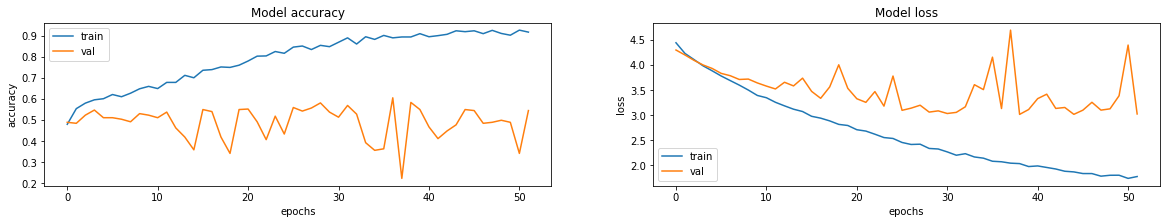

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Dimension of the MRI scan is: (128, 128, 64)


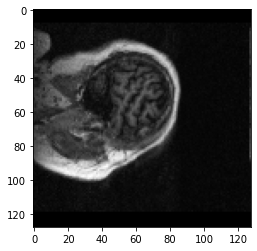

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

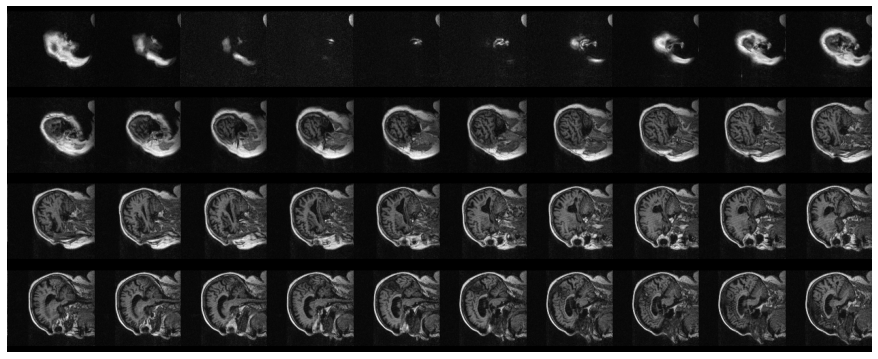

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [ ]:
!pip install pydot

In [ ]:
keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
